# Coursework 2 – Machine Learning  
## Image Classification
**Student Name:** Bakhtiyor Sohibnazarov   
**Student ID:** Z22590018   
**Module:** Machine Learning   
**Updated:** 1st December 2025  

## Project Overview
The goal of this project is to develop a supervised learning model capable of accurately classifying images into multiple categories. The Intel Image Classification Dataset is used, which contains labeled images of various classes.  

## Importing Libraries
We will use the following libraries for this task:

- **TensorFlow/Keras**: Build and train the neural network.
- **NumPy**: Array manipulation and numerical operations.
- **Matplotlib**: Visualize accuracy, loss, and results.
- **kagglehub**: Download dataset from Kaggle.
- **Scikit-learn**: To visualize confusion matrix

If any library is missing, it can be installed using pip. Run command below

In [1]:
""" pip command to install above packages for our ML model to run.
Please note TensorFlow will take around 650MB of Storage space. 
Make sure you have sufficient storage before running this notebook
Remove -q argument to see the install progress """

!pip -q install tensorflow numpy matplotlib kagglehub scikit-learn

In [5]:
# Import Required Libraries
import os
import shutil

# To download dataset if it does not exist
import kagglehub

# NumPy for numerical and array manipulation
import numpy as np

# Matplotlib for plotting and seaborn for graphs
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow and Keras for building and training the neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory


## Loading and Organising Dataset
We use the Intel Image Classification dataset. Kagglehub downloads the dataset to a default cache directory, so we move it to a working directory called `intel-data`.  

In [6]:
# Get currect working directory
current_dir = os.getcwd()

# Define target directory to copy dataset
target_dir = os.path.join(current_dir, "intel-data")

# Check if Directory exists
if os.path.exists(target_dir):
    print("Directory already exists. Please Continue below or delete intel-data directory to download data again")
    pass
else:
    
    # Download Intel Image Classification Dataset and capture its path in below variable
    path = kagglehub.dataset_download("puneet6060/intel-image-classification")
    print("Download Path: ", path)

    # Move from cache to target directory
    shutil.move(path, target_dir)
    print("Moved to: ", target_dir)

Directory already exists. Please Continue below or delete intel-data directory to download data again


## Prepare Training and Validation Sets
The `image_dataset_from_directory` utility automatically reads images from folders, assigns labels based on subfolder names, and prepares batches for training.  

- **Training set and Validation sets**: Pre-Split data from intel dataset
- **Batch size**: 32 images per batch. Can be increase when training for production
- **Image size**: Original stock image sizes are 150x150, with 3 color channels (RGB)

In [8]:
# Assign global tensorflow seed to change randomness to predictable random number
# tf.random.set_seed(10)

# Assign corresponding directories to variables.
train_dir = os.path.join(target_dir, "seg_train/seg_train")

# Training data 80% split
train_data = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=10,
    image_size=(150,150),
    batch_size=32,
    label_mode='categorical'
)

# Validation Data 20% split
val_data = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=10,
    image_size=(150,150),
    batch_size=32,
    label_mode='categorical',
)

# Gets and stores number of classes
num_classes = len(train_data.class_names)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


## Convolutional Neural Network (CNN) Architecture
The CNN consists of:

1. **Input Layer**: Accept images
2. **Conv2D + MaxPooling Layers**: Extract features from images.
3. **GlobalAveragePooling Layer**: Converts 2D feature maps into a 1D vector.
4. **Dense Layer**: Fully connected layer with specified number of neurons.
5. **Dropout**: To prevent overfitting. Enable it when using large number of neurons
6. **Output Layer**: Specify number of classes, with softmax activation for multi-class classification.


In [11]:
# Randomize image to improve generalization. 
# Please note that augmentation affected by global seed set above.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

train_data = (
    train_data
    .shuffle(1000, reshuffle_each_iteration=True)
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)
val_data = val_data.batch(32).prefetch(tf.data.AUTOTUNE)

# Sequential Model is used 
model = Sequential([
    # Specifies downscaled input 128x128, 3 channels. Means 3 channel colors RGB
    Input(shape=(150,150,3)),

    # First convolution block, uses activation Rectified Linear Unit. Applies 32 filters, 3x3 pixel
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2), # Get Stronges pixels 2x2
    
    # Second Convolution block with 64 filters applied
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # 3rd convolution block with 128 filters applied
    Conv2D(128, (3,3), activation='relu'),
    GlobalAveragePooling2D(), # Alternative to Flatten()

    # Fully connected Layer with neurons. Decision making layer. Increase number of neurons when on large epochs
    Dense(150, activation='relu'),

    # Disables given amount of neurons to prevent model overfitting
    # Uncomment below when on large neurons to drop
    Dropout(0.5),

    # Output layer. gives prediction using softmax to 6 classes (num_classes) defined above
    Dense(num_classes, activation='softmax')
])

model.summary()

ValueError: in user code:

    File "/tmp/ipykernel_5415/3932310623.py", line 12, in None  *
        lambda x, y: (data_augmentation(x, training=True), y)
    File "/home/bakhtiyor/Desktop/MLCW2/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/bakhtiyor/Desktop/MLCW2/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/image_preprocessing/base_image_preprocessing_layer.py", line 126, in _is_batched
        raise ValueError(

    ValueError: Exception encountered when calling RandomFlip.call().
    
    [1mExpected image tensor to have rank 3 (single image) or 4 (batch of images). Received: data.shape=(<tf.Tensor 'sequential_2_1/random_flip_2_1/strided_slice_3:0' shape=() dtype=int32>, <tf.Tensor 'sequential_2_1/random_flip_2_1/strided_slice_4:0' shape=() dtype=int32>, <tf.Tensor 'sequential_2_1/random_flip_2_1/strided_slice_5:0' shape=() dtype=int32>, 150, 150, 3)[0m
    
    Arguments received by RandomFlip.call():
      • data=tf.Tensor(shape=(None, None, None, 150, 150, 3), dtype=float32)
      • training=True


## Compile and Train the Model
- **Optimizer**: Adam optimizer for efficient gradient descent.
- **Loss function**: Categorical crossentropy for multi-class classification.
- **Metrics**: Accuracy to monitor model performance.

We train the model for 8 epochs with the training and validation datasets.

In [8]:
# Compile model. Uses adam optimizer and tries to minimize loss categorical_crossentropy
model.compile(
optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy']
)

# Start Training
history = model.fit(
train_data,
validation_data=val_data,
epochs=20
)

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 84s 235ms/step - accuracy: 0.4599 - loss: 1.4900 - val_accuracy: 0.6158 - val_loss: 1.0423
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 231ms/step - accuracy: 0.5861 - loss: 1.0440 - val_accuracy: 0.6251 - val_loss: 1.0745
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 231ms/step - accuracy: 0.6381 - loss: 0.9602 - val_accuracy: 0.6532 - val_loss: 0.9538
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 82s 234ms/step - accuracy: 0.6687 - loss: 0.8843 - val_accuracy: 0.6867 - val_loss: 0.8758
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 231ms/step - accuracy: 0.7003 - loss: 0.8237 - val_accuracy: 0.7334 - val_loss: 0.8090
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 82s 232ms/step - accuracy: 0.7146 - loss: 0.7853 - val_accuracy: 0.7634 - val_loss: 0.6991
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 82s 233ms/step - accuracy: 0.7389 - loss: 0.7241 - val_accuracy: 0.7555 - val_loss: 0.7205
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 82s 233ms/step - accuracy: 0.7594 - loss: 0

## Training Evaluation
We evaluate the model training metrics using:

**Accuracy and Loss Plots**: Shows training vs validation performance over epochs.

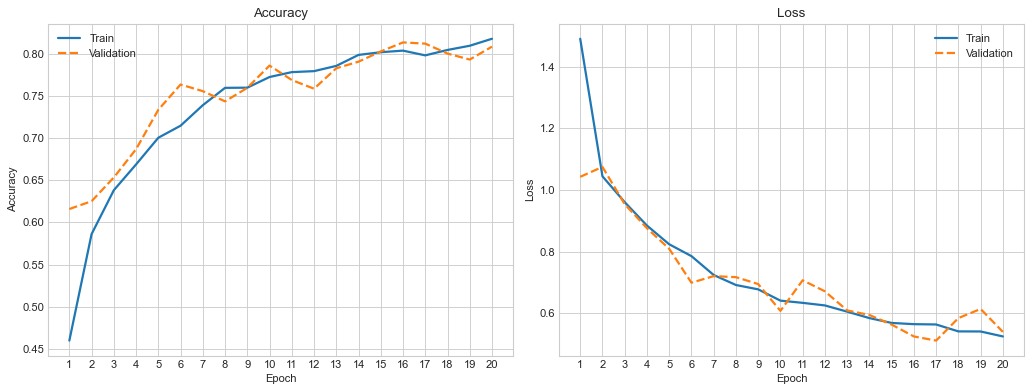

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.style.use("seaborn-v0_8-whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(13, 5), dpi=80)

# Accuracy
ax[0].plot(epochs, acc, label='Train', linewidth=2)
ax[0].plot(epochs, val_acc, '--', label='Validation', linewidth=2)
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticks(epochs)
ax[0].legend()

# Loss
ax[1].plot(epochs, loss, label='Train', linewidth=2)
ax[1].plot(epochs, val_loss, '--', label='Validation', linewidth=2)
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xticks(epochs)
ax[1].legend()

plt.tight_layout()
plt.show()

**Confusion Matrix**: Illustrates correct vs incorrect predictions for each class.

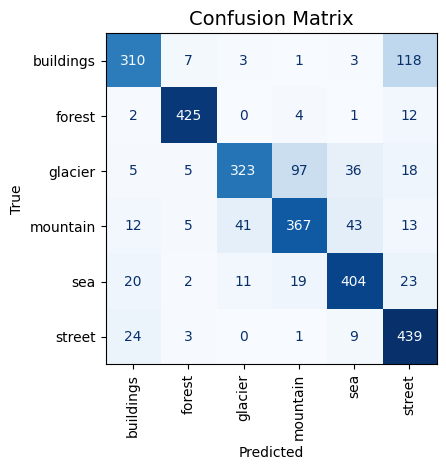

In [10]:
# Collect predictions for entire validation set
y_true = []
y_pred = []

for x, y in val_data:
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(model(x, training=False), axis=1).numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.style.use('default')

disp = ConfusionMatrixDisplay(cm, display_labels=train_data.class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical', colorbar=False)

plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## Test and Evaluate Trained Model
Using Intel Image Classification test dataset, we can evaluate our trained model using unbiased data to check how well it performs

Found 3000 files belonging to 6 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.8120 - loss: 0.5402


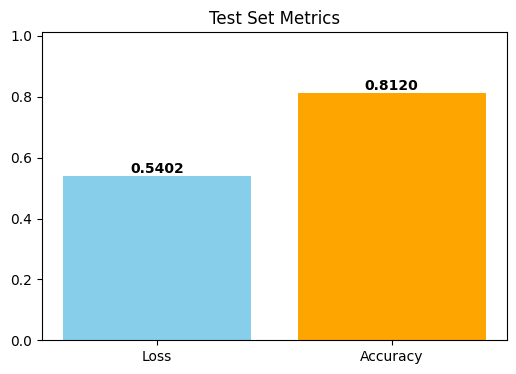

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step
[[ 58  73  54  56  81 115]
 [ 68  81  60  90  80  95]
 [ 72  86  71 109 102 113]
 [ 65  87  66 103 102 102]
 [ 71  70  72 106  93  98]
 [ 67  76  71  96  85 106]]


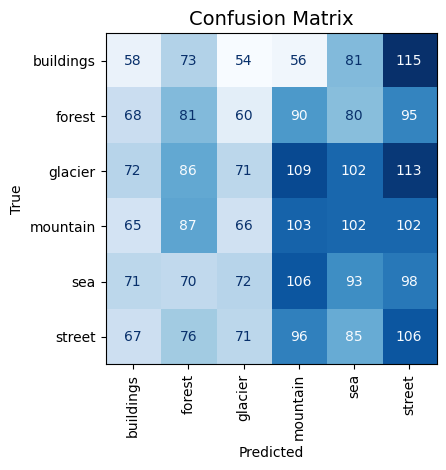

In [17]:
# Evaluate on test set after training

# Assign corresponding directories to variables.
test_dir = os.path.join(target_dir, "seg_test/seg_test")

test_data = image_dataset_from_directory(
    test_dir,
    image_size=(150,150),
    batch_size=32,
    label_mode='categorical'
)

test_loss, test_acc = model.evaluate(test_data)

# Test metrics
metrics = [test_loss, test_acc]
labels = ['Loss', 'Accuracy']

plt.figure(figsize=(6,4))
plt.bar(labels, metrics, color=['skyblue', 'orange'])
plt.title("Test Set Metrics")
for i, v in enumerate(metrics):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')
plt.ylim(0, max(metrics)+0.2)
plt.show()


y_test_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_data])
y_test_pred = np.argmax(model.predict(test_data), axis=1)

test_cm = confusion_matrix(y_test_true, y_test_pred)
print(test_cm)

plt.style.use('default')

test_disp = ConfusionMatrixDisplay(test_cm, display_labels=test_data.class_names)
test_disp.plot(cmap='Blues', xticks_rotation='vertical', colorbar=False)

plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## Interactive Testing

Intel Image Classification Dataset used in this coursework offers other directory called seg_pred without labels. The images can be used to test already trained model to see if our model working as expected. User required image to upload and model expected to predict what image represent using trained labels.

In [13]:
from IPython.display import display, clear_output
import ipywidgets as widgets
from PIL import Image
import io

upload = widgets.FileUpload(accept='image/*', multiple=False)
upload

FileUpload(value=(), accept='image/*', description='Upload')

In [15]:
# Create an output widget to capture cell output
out = widgets.Output()

# Define what happens when the button is clicked
def run_cell(b):
    with out:
        clear_output()  # clear previous output


        if upload.value:
            # Handle both tuple and dict formats
            file_obj = upload.value[0] if isinstance(upload.value, tuple) else list(upload.value.values())[0]
        
            # Read file bytes
            img = Image.open(io.BytesIO(file_obj['content'])).convert('RGB')
        
            # Resize for model
            img_resized = img.resize((128, 128))
            img_array = np.array(img_resized) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
        
            # Predict
            preds = model.predict(img_array)
            pred_class = train_data.class_names[np.argmax(preds)]
        
            # Display
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            print("Predicted class:", pred_class)

# Create the button
button = widgets.Button(description="Run Test Evaluation")
button.on_click(run_cell)

# Display the button and output area
display(button, out)


Button(description='Run Test Evaluation', style=ButtonStyle())

Output()